In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf

C:\Users\vnuretdi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\vnuretdi\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Load the data

In [3]:
train = pd.read_csv('training.csv')
test=pd.read_csv('test.csv')

In [4]:
ids=pd.read_csv("IdLookupTable.csv")

In [5]:
sample=pd.read_csv("SampleSubmission.csv")

### Transform the data for the Tensorflow model

#### Extract values with full data on facepoints to be used for the first train iteration

In [64]:
df=train.dropna()
df.shape

(2140, 31)

#### Create X and Y values which will be used as Tensorflow input data. Normalize both X and Y

In [7]:
image = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
X = np.vstack(image.values) / 255 
X = X.astype(np.float64)

In [8]:
Y = df.drop(['Image'], axis=1).values
Y = (Y - 48) / 48  
Y = Y.astype(np.float64)

### Add new observations by flipping the images horizontally

In [9]:
from copy import copy, deepcopy

X1=deepcopy(X)

for i in range(len(X1)):
    a1=np.reshape(X1[i],(96,96))
    a1=np.flip(a1, 1)
    a1=np.reshape(a1,(96*96,))
    X1[i]=a1

Y1=deepcopy(Y)

for i in range(len(Y1)):
    Y1[i][0::2]=-Y1[i][0::2]
    Y1[i]=Y1[i][[2,3,0,1,8,9,10,11,4,5,6,7,16,17,18,19,12,13,14,15,20,21,24,25,22,23,26,27,28,29]]

In [37]:
### extend X and Y inputs to the newly obtained observations
X_ext=np.append(X, X1, axis=0)
Y_ext=np.append(Y, Y1, axis=0)

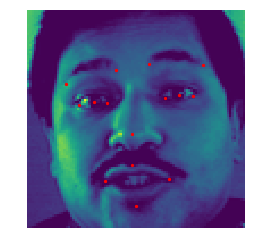

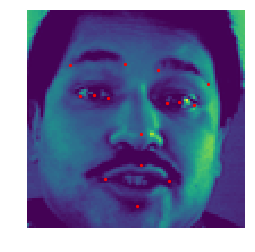

In [152]:
### Check an example of initial and flipped image
k=250
a=np.reshape(X[k],(96,96))
plt.imshow(a)
plt.axis("off")
for i in range(15):
    plt.scatter((Y[k][2*i]+1)*48,(Y[k][2*i+1]+1)*48, c="red", s=5)
plt.show()


a=np.reshape(X1[k],(96,96))
plt.imshow(a)
plt.axis("off")
for i in range(15):
    plt.scatter((Y1[k][2*i]+1)*48,(Y1[k][2*i+1]+1)*48, c="red", s=5)
    #plt.annotate(names[2*i], xy=((Y[k][2*i]+1)*48, (Y[k][2*i+1]+1)*48), color='red', fontsize=10)    
plt.show()

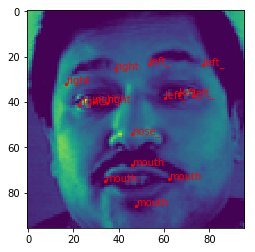

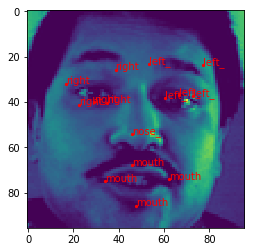

In [39]:
# Check that I have replaced right and left values in the correct way

names=df.columns[:-1]
a=np.reshape(X[k],(96,96))
plt.imshow(a)
for i in range(15):
    plt.scatter((Y[k][2*i]+1)*48,(Y[k][2*i+1]+1)*48, c="red", s=5)
    plt.annotate(str(names[2*i])[:5], xy=((Y[k][2*i]+1)*48, (Y[k][2*i+1]+1)*48), color='red', fontsize=10)   
plt.show()


a=np.reshape(X1[k],(96,96))
plt.imshow(a)
for i in range(15):
    plt.scatter((Y[k][2*i]+1)*48,(Y[k][2*i+1]+1)*48, c="red", s=5)
    plt.annotate(str(names[2*i])[:5], xy=((Y[k][2*i]+1)*48, (Y[k][2*i+1]+1)*48), color='red', fontsize=10)    
plt.show()

In [1145]:
X_ext.shape

(4280, 9216)

### Build first Tensorflow model based on 4280 complete observations

In [13]:
image_size=96
num_keypoints=30
layer_1=150

In [14]:
# input
x=tf.placeholder(tf.float64, shape = (None, image_size * image_size))
y=tf.placeholder(tf.float64, shape = (None, num_keypoints))

# Input to hidden
W = tf.Variable(np.zeros(shape=[image_size * image_size, layer_1]))
b= tf.Variable(np.zeros(shape=[layer_1]))

#Hidden layers
V1= tf.Variable(np.zeros(shape=[layer_1, num_keypoints]))
b1=tf.Variable(np.zeros(shape=[num_keypoints]))

# Model

H1 = tf.matmul(x,W) + b
yhat = tf.matmul(H1,V1) + b1

In [15]:
## MSE
mse = tf.reduce_mean(tf.square(yhat - y))
## Regularization Penalty
lam = .05
reg = tf.reduce_mean(lam * tf.square(W)) + tf.reduce_mean(lam * tf.square(V1))

# Loss
loss = mse + reg

# Optimizer
train_step = tf.train.AdamOptimizer(0.01).minimize(loss)

In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [40]:
sess.run(mse, feed_dict={x: X_ext, y: Y_ext})

0.005075076189928503

In [41]:
for i in range(100):
    sess.run(train_step, feed_dict={x: X_ext, y: Y_ext})

In [42]:
sess.run(mse, feed_dict={x: X_ext, y: Y_ext})

0.0044159438571336482

## Use the first model to complete the observations with NA's

In [20]:
incomplete=train[train.isnull().any(axis=1)]

In [21]:
incomplete.shape

(4909, 31)

In [22]:
image_incomp=incomplete['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

In [23]:
X_incomp=np.vstack(image_incomp.values) / 255
X_incomp = X_incomp.astype(np.float64)

In [24]:
Y_incomp=incomplete.drop(['Image'], axis=1).values
Y_incomp=(Y_incomp-48)/48
Y_incomp=Y_incomp.astype(np.float64)

In [25]:
print(X_incomp.shape, Y_incomp.shape)

(4909, 9216) (4909, 30)


In [26]:
results=sess.run(yhat, feed_dict={x: X_incomp})

### Let's look at a few examples on how the incomplete facepoint data would be completed based on the model
(blue are real available values, red are calcualted values)

In [150]:
def getimage(k):
    a=np.reshape(X_incomp[k],(96,96))
    plt.imshow(a)
    for i in range(15):
        y_axis=int((results[k][2*i+1]+1)*48)
        x_axis=int((results[k][2*i]+1)*48)
        plt.axis("off")
        #if (np.nan_to_num(Y_incomp[k][2*i])==0):
            #plt.scatter(x_axis, y_axis, s=10, c='red', marker='x')
        if (np.nan_to_num(Y_incomp[k][2*i])!=0):
            plt.scatter(np.nan_to_num(Y_incomp[k][2*i]+1)*48, np.nan_to_num(Y_incomp[k][2*i+1]+1)*48, s=5, c='blue', marker='o')
    plt.show()

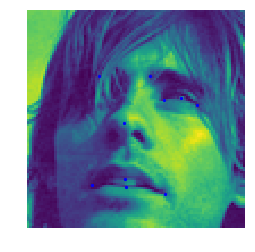

In [151]:
getimage(100)

### Let's complete Y values and add new observations

In [27]:
for i in range(len(Y_incomp)):
    ind=np.argwhere(np.isnan(Y_incomp[i]))
    Y_incomp[i][ind]=results[i][ind]

In [28]:
np.argwhere(np.isnan(Y_incomp))

array([], shape=(0, 2), dtype=int64)

In [29]:
X_ext=np.append(X_ext, X_incomp, axis=0)
Y_ext=np.append(Y_ext, Y_incomp, axis=0)

print(X_ext.shape, Y_ext.shape)

(9189, 9216) (9189, 30)


## Build Tensorflow model based on 9189 observations

In [30]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

sess.run(mse, feed_dict={x: X_ext, y: Y_ext})

0.14956627830429972

In [31]:
for i in range(100):
    sess.run(train_step, feed_dict={x: X_ext, y: Y_ext})

In [32]:
sess.run(mse, feed_dict={x: X_ext, y: Y_ext})

0.0037533649685022406

## Transform test data and build the facepoints

In [95]:
image_test=test.Image.apply(lambda im: np.fromstring(im, sep = ' '))
X_test=np.vstack(image_test.values) / 255
X_test = X_test.astype(np.float64)

### Review a couple of test examples

In [42]:
results=sess.run(yhat, feed_dict={x: X_test})

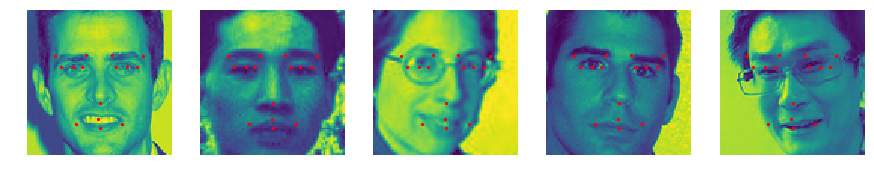

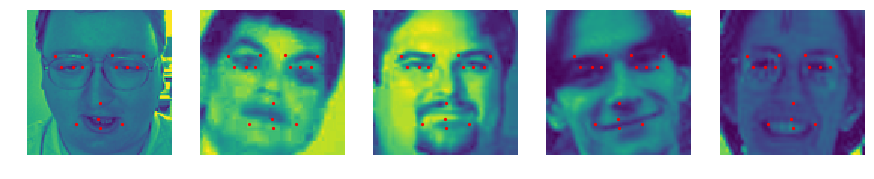

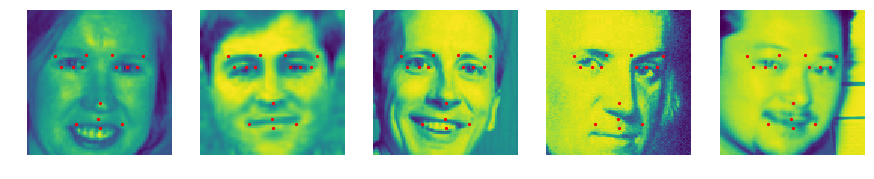

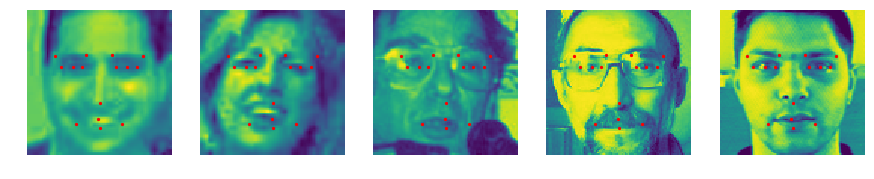

In [43]:
ind=(list(np.random.choice(range(len(X_test)),20)))

for i in range(4): 
    fig, ax = plt.subplots(1,5, figsize=(15,3))  
    
    for j, k in enumerate(ind[i*5:(i*5+5)]):
        a=np.reshape(X_test[k],(96,96))
        ax[j].axis('off') 
        ax[j].imshow(a)
        for i in range(15):
            y_axis=int((results[k][2*i+1]+1)*48)
            x_axis=int((results[k][2*i]+1)*48)
            ax[j].scatter(x_axis, y_axis, s=5, c='red', marker='o')
    plt.show()

#### Create the submission file based on the RF model prediction results

In [1094]:
ids.ImageId-=1
ids.index=ids.ImageId

In [706]:
names=list(train.columns[:-1])

In [1095]:
ids.head()

,RowId,ImageId,FeatureName,Location
ImageId,,,,
0,1,0,left_eye_center_x,NaN
0,2,0,left_eye_center_y,NaN
0,3,0,right_eye_center_x,NaN
0,4,0,right_eye_center_y,NaN
0,5,0,left_eye_inner_corner_x,NaN


In [1128]:
for k in range(1783):
    if len(ids.loc[ids.ImageId==k])==30:
        ids.loc[ids.ImageId==k, "Location"]=(results[k]+1)*48
    else:
        present=[i for i in range(30) if names[i] in ids.loc[ids.ImageId==k, "FeatureName"].values]
        ids.loc[ids.ImageId==k, "Location"]=(results[k][present]+1)*48

In [1129]:
results.shape

(1783, 30)

In [1130]:
submission=ids[["RowId","Location"]]

In [1131]:
submission.to_csv("submission.csv", index=False)

In [1132]:
submission.shape

(27124, 2)

## Test models on new images (flipped incomplete data)

In [34]:
from copy import copy, deepcopy

X1_incomp=deepcopy(X_incomp)

for i in range(len(X1_incomp)):
    a1=np.reshape(X1_incomp[i],(96,96))
    a1=np.flip(a1, 1)
    a1=np.reshape(a1,(96*96))
    X1_incomp[i]=a1

#return initial incomplete data
Y_incomp=incomplete.drop(['Image'], axis=1).values
Y_incomp=(Y_incomp-48)/48
Y_incomp=Y_incomp.astype(np.float64)
Y1_incomp=deepcopy(Y_incomp)

for i in range(len(Y1_incomp)):
    Y1_incomp[i][0::2]=-Y1_incomp[i][0::2]
    Y1_incomp[i]=Y1_incomp[i][[2,3,0,1,8,9,10,11,4,5,6,7,16,17,18,19,12,13,14,15,20,21,24,25,22,23,26,27,28,29]]

X1_incomp.shape

(4909, 9216)

## Model based on 9K observations

In [157]:
results1=sess.run(yhat, feed_dict={x: X1_incomp})
((np.nansum((results1-Y1_incomp)**2)*(48**2))/(np.sum(np.isnan(Y1_incomp))))**0.5

3.465481760099828

## Model based on 16K observations

In [153]:
results2=sess.run(yhat, feed_dict={x: X1_incomp})
((np.nansum((results2-Y1_incomp)**2)*(48**2))/(np.sum(np.isnan(Y1_incomp))))**0.5

2.9319158454694079